In [1]:
import pandas as pd

# Dataset paths (replace with your actual dataset paths)
train_path = "../Data/train.csv"  # Replace with your dataset
test_path = "../Datatest.csv"

print("Loading datasets...")

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Train dataset loaded with {len(train_df)} rows and {len(train_df.columns)} columns.")
print(f"Test dataset loaded with {len(test_df)} rows and {len(test_df.columns)} columns.")

# Data cleaning
print("Cleaning datasets...")
train_df = train_df.dropna(subset=["text", "label"])
train_df = train_df[train_df["text"].str.strip() != ""]
test_df = test_df.dropna(subset=["text", "label"])
test_df = test_df[test_df["text"].str.strip() != ""]

# Convert labels to integers
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

print(f"Train dataset size after cleaning: {len(train_df)} rows.")
print(f"Test dataset size after cleaning: {len(test_df)} rows.")

# Save cleaned data for debugging (optional)
train_df.to_csv("../Data/cleaned_train.csv", index=False)
test_df.to_csv("../Data/cleaned_test.csv", index=False)

print("Data preprocessing completed.")


Loading datasets...
Train dataset loaded with 24048 rows and 2 columns.
Test dataset loaded with 6680 rows and 2 columns.
Cleaning datasets...
Train dataset size after cleaning: 24046 rows.
Test dataset size after cleaning: 6680 rows.
Data preprocessing completed.


**Visualize Class Distribution**

Visualizing class distribution...


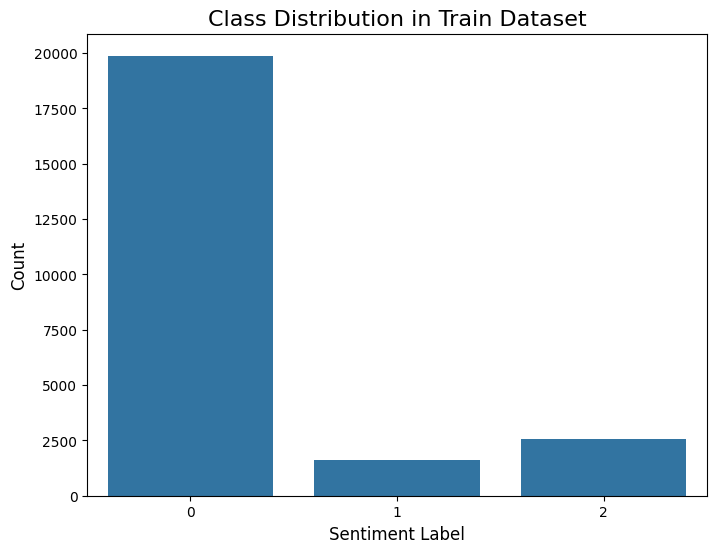

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize class distribution
print("Visualizing class distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=train_df)
plt.title("Class Distribution in Train Dataset", fontsize=16)
plt.xlabel("Sentiment Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


**Visualize Text Length Distribution**

Visualizing text length distribution...


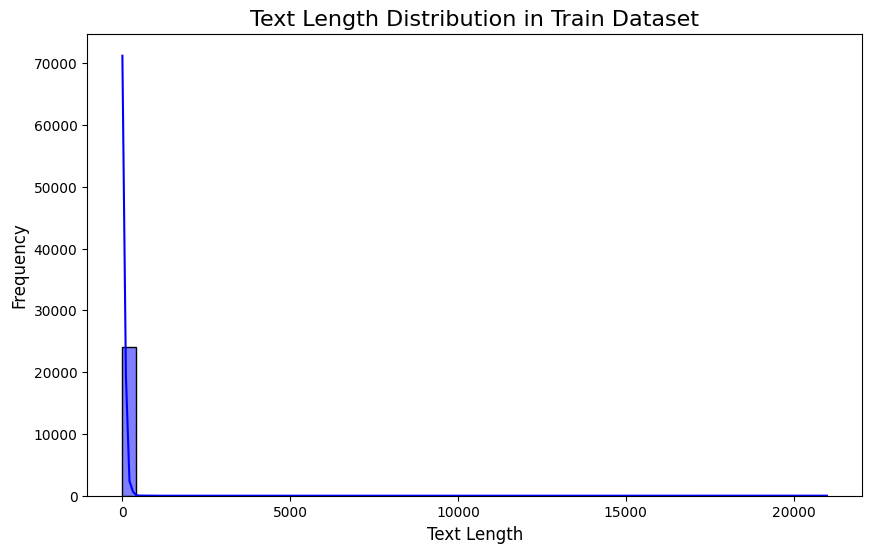

In [3]:
# Add a column for text length
train_df["text_length"] = train_df["text"].apply(len)

# Visualize text length distribution
print("Visualizing text length distribution...")
plt.figure(figsize=(10, 6))
sns.histplot(train_df["text_length"], bins=50, kde=True, color="blue")
plt.title("Text Length Distribution in Train Dataset", fontsize=16)
plt.xlabel("Text Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [4]:
!pip install -q transformers torch


In [5]:
from transformers import RobertaForSequenceClassification, AutoTokenizer
import torch

# Load phoBERT tokenizer and model
print("Loading phoBERT model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = RobertaForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded and moved to device: {device}")


c:\Users\phamd\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading phoBERT model and tokenizer...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device: cuda


**Prepare the Dataset**

In [6]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Example for dataset preparation
max_len = 256
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len)

print("Datasets prepared:")
print(f"  Training dataset size: {len(train_dataset)}")
print(f"  Test dataset size: {len(test_dataset)}")


Datasets prepared:
  Training dataset size: 24046
  Test dataset size: 6680


**Define Training Arguments**

In [7]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./phobert-sentiment-output",
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Accuracy as the evaluation metric
    logging_dir="./logs",
)

print("TrainingArguments configured.")


c:\Users\phamd\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



TrainingArguments configured.


**Add Accuracy Metric**

In [8]:
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}


**Initialize the Trainer**

In [9]:
from transformers import Trainer
from transformers import DataCollatorWithPadding

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
print("Initializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Custom accuracy metric
)

print("Trainer initialized.")


Initializing Trainer...
Trainer initialized.


In [11]:
print("Starting training...")
try:
    trainer.train()
    print("Training complete.")
except Exception as e:
    print(f"An error occurred during training: {e}")


Starting training...


  2%|▏         | 100/4509 [00:49<37:26,  1.96it/s]

{'loss': 0.5896, 'grad_norm': 1.8829458951950073, 'learning_rate': 1.9556442670215127e-05, 'epoch': 0.07}


  4%|▍         | 200/4509 [01:38<34:09,  2.10it/s]

{'loss': 0.5108, 'grad_norm': 11.09934139251709, 'learning_rate': 1.9112885340430253e-05, 'epoch': 0.13}


  7%|▋         | 300/4509 [02:25<33:26,  2.10it/s]

{'loss': 0.4584, 'grad_norm': 8.599227905273438, 'learning_rate': 1.866932801064538e-05, 'epoch': 0.2}


  9%|▉         | 400/4509 [03:13<32:37,  2.10it/s]

{'loss': 0.4601, 'grad_norm': 8.016219139099121, 'learning_rate': 1.82257706808605e-05, 'epoch': 0.27}


 11%|█         | 500/4509 [04:01<31:56,  2.09it/s]

{'loss': 0.4615, 'grad_norm': 14.932679176330566, 'learning_rate': 1.7782213351075627e-05, 'epoch': 0.33}


 13%|█▎        | 600/4509 [04:49<31:17,  2.08it/s]

{'loss': 0.4505, 'grad_norm': 3.8661861419677734, 'learning_rate': 1.7338656021290753e-05, 'epoch': 0.4}


 16%|█▌        | 700/4509 [05:37<30:34,  2.08it/s]

{'loss': 0.3992, 'grad_norm': 5.27877140045166, 'learning_rate': 1.689509869150588e-05, 'epoch': 0.47}


 18%|█▊        | 800/4509 [06:25<29:29,  2.10it/s]

{'loss': 0.4183, 'grad_norm': 7.45208740234375, 'learning_rate': 1.6451541361721004e-05, 'epoch': 0.53}


 20%|█▉        | 900/4509 [07:13<28:53,  2.08it/s]

{'loss': 0.4365, 'grad_norm': 9.977294921875, 'learning_rate': 1.600798403193613e-05, 'epoch': 0.6}


 22%|██▏       | 1000/4509 [08:02<28:03,  2.08it/s]

{'loss': 0.4085, 'grad_norm': 4.522458076477051, 'learning_rate': 1.5564426702151256e-05, 'epoch': 0.67}


 24%|██▍       | 1100/4509 [08:50<27:16,  2.08it/s]

{'loss': 0.3594, 'grad_norm': 6.38805627822876, 'learning_rate': 1.512086937236638e-05, 'epoch': 0.73}


 27%|██▋       | 1200/4509 [09:38<26:38,  2.07it/s]

{'loss': 0.3796, 'grad_norm': 7.280864715576172, 'learning_rate': 1.4677312042581504e-05, 'epoch': 0.8}


 29%|██▉       | 1300/4509 [10:26<25:34,  2.09it/s]

{'loss': 0.3786, 'grad_norm': 16.02516746520996, 'learning_rate': 1.423375471279663e-05, 'epoch': 0.86}


 31%|███       | 1400/4509 [11:14<25:07,  2.06it/s]

{'loss': 0.3986, 'grad_norm': 9.745518684387207, 'learning_rate': 1.3790197383011757e-05, 'epoch': 0.93}


 33%|███▎      | 1500/4509 [12:03<24:17,  2.06it/s]

{'loss': 0.379, 'grad_norm': 6.120485305786133, 'learning_rate': 1.3346640053226881e-05, 'epoch': 1.0}


                                                   
 33%|███▎      | 1503/4509 [13:03<23:18,  2.15it/s]

{'eval_loss': 0.3714314103126526, 'eval_accuracy': 0.8642215568862276, 'eval_runtime': 58.6174, 'eval_samples_per_second': 113.959, 'eval_steps_per_second': 7.131, 'epoch': 1.0}


 35%|███▌      | 1600/4509 [13:51<23:11,  2.09it/s]   

{'loss': 0.3157, 'grad_norm': 5.21946907043457, 'learning_rate': 1.2903082723442007e-05, 'epoch': 1.06}


 38%|███▊      | 1700/4509 [14:39<22:24,  2.09it/s]

{'loss': 0.3516, 'grad_norm': 3.1241700649261475, 'learning_rate': 1.245952539365713e-05, 'epoch': 1.13}


 40%|███▉      | 1800/4509 [15:27<21:45,  2.08it/s]

{'loss': 0.3348, 'grad_norm': 24.233308792114258, 'learning_rate': 1.2015968063872256e-05, 'epoch': 1.2}


 42%|████▏     | 1900/4509 [16:15<20:45,  2.10it/s]

{'loss': 0.2895, 'grad_norm': 6.822190284729004, 'learning_rate': 1.1572410734087382e-05, 'epoch': 1.26}


 44%|████▍     | 2000/4509 [17:03<20:10,  2.07it/s]

{'loss': 0.316, 'grad_norm': 8.746302604675293, 'learning_rate': 1.1128853404302506e-05, 'epoch': 1.33}


 47%|████▋     | 2100/4509 [17:51<19:10,  2.09it/s]

{'loss': 0.3051, 'grad_norm': 9.677497863769531, 'learning_rate': 1.0685296074517632e-05, 'epoch': 1.4}


 49%|████▉     | 2200/4509 [18:39<18:24,  2.09it/s]

{'loss': 0.3144, 'grad_norm': 22.444677352905273, 'learning_rate': 1.0241738744732756e-05, 'epoch': 1.46}


 51%|█████     | 2300/4509 [19:27<17:40,  2.08it/s]

{'loss': 0.2947, 'grad_norm': 7.527792453765869, 'learning_rate': 9.798181414947883e-06, 'epoch': 1.53}


 53%|█████▎    | 2400/4509 [20:15<16:47,  2.09it/s]

{'loss': 0.3606, 'grad_norm': 11.83224868774414, 'learning_rate': 9.354624085163007e-06, 'epoch': 1.6}


 55%|█████▌    | 2500/4509 [21:03<16:03,  2.09it/s]

{'loss': 0.3483, 'grad_norm': 4.589449405670166, 'learning_rate': 8.911066755378133e-06, 'epoch': 1.66}


 58%|█████▊    | 2600/4509 [21:50<15:09,  2.10it/s]

{'loss': 0.3082, 'grad_norm': 1.0524613857269287, 'learning_rate': 8.467509425593259e-06, 'epoch': 1.73}


 60%|█████▉    | 2700/4509 [22:38<14:26,  2.09it/s]

{'loss': 0.3109, 'grad_norm': 8.145718574523926, 'learning_rate': 8.023952095808385e-06, 'epoch': 1.8}


 62%|██████▏   | 2800/4509 [23:26<13:33,  2.10it/s]

{'loss': 0.3069, 'grad_norm': 12.382615089416504, 'learning_rate': 7.580394766023509e-06, 'epoch': 1.86}


 64%|██████▍   | 2900/4509 [24:14<12:45,  2.10it/s]

{'loss': 0.3324, 'grad_norm': 24.495088577270508, 'learning_rate': 7.136837436238634e-06, 'epoch': 1.93}


 67%|██████▋   | 3000/4509 [25:02<12:06,  2.08it/s]

{'loss': 0.2767, 'grad_norm': 8.291756629943848, 'learning_rate': 6.69328010645376e-06, 'epoch': 2.0}


                                                   
 67%|██████▋   | 3006/4509 [26:03<11:35,  2.16it/s]

{'eval_loss': 0.39158305525779724, 'eval_accuracy': 0.8748502994011976, 'eval_runtime': 58.0553, 'eval_samples_per_second': 115.063, 'eval_steps_per_second': 7.2, 'epoch': 2.0}


 69%|██████▉   | 3100/4509 [26:49<11:14,  2.09it/s]  

{'loss': 0.2922, 'grad_norm': 12.500685691833496, 'learning_rate': 6.249722776668885e-06, 'epoch': 2.06}


 71%|███████   | 3200/4509 [27:37<10:25,  2.09it/s]

{'loss': 0.2436, 'grad_norm': 11.133870124816895, 'learning_rate': 5.80616544688401e-06, 'epoch': 2.13}


 73%|███████▎  | 3300/4509 [28:25<09:38,  2.09it/s]

{'loss': 0.2512, 'grad_norm': 14.586469650268555, 'learning_rate': 5.362608117099135e-06, 'epoch': 2.2}


 75%|███████▌  | 3400/4509 [29:13<08:51,  2.09it/s]

{'loss': 0.258, 'grad_norm': 10.852442741394043, 'learning_rate': 4.919050787314261e-06, 'epoch': 2.26}


 78%|███████▊  | 3500/4509 [30:01<08:01,  2.10it/s]

{'loss': 0.2508, 'grad_norm': 7.902909755706787, 'learning_rate': 4.475493457529386e-06, 'epoch': 2.33}


 80%|███████▉  | 3600/4509 [30:48<07:14,  2.09it/s]

{'loss': 0.2649, 'grad_norm': 3.8016631603240967, 'learning_rate': 4.031936127744511e-06, 'epoch': 2.4}


 82%|████████▏ | 3700/4509 [31:36<06:26,  2.10it/s]

{'loss': 0.2469, 'grad_norm': 5.417016983032227, 'learning_rate': 3.588378797959637e-06, 'epoch': 2.46}


 84%|████████▍ | 3800/4509 [32:24<05:39,  2.09it/s]

{'loss': 0.2701, 'grad_norm': 28.359407424926758, 'learning_rate': 3.144821468174762e-06, 'epoch': 2.53}


 86%|████████▋ | 3900/4509 [33:12<04:51,  2.09it/s]

{'loss': 0.2856, 'grad_norm': 9.926012992858887, 'learning_rate': 2.7012641383898867e-06, 'epoch': 2.59}


 89%|████████▊ | 4000/4509 [34:00<04:02,  2.10it/s]

{'loss': 0.2482, 'grad_norm': 14.473902702331543, 'learning_rate': 2.2577068086050125e-06, 'epoch': 2.66}


 91%|█████████ | 4100/4509 [34:48<03:15,  2.09it/s]

{'loss': 0.2354, 'grad_norm': 9.400639533996582, 'learning_rate': 1.8141494788201378e-06, 'epoch': 2.73}


 93%|█████████▎| 4200/4509 [35:35<02:28,  2.08it/s]

{'loss': 0.248, 'grad_norm': 4.686777114868164, 'learning_rate': 1.370592149035263e-06, 'epoch': 2.79}


 95%|█████████▌| 4300/4509 [36:23<01:39,  2.10it/s]

{'loss': 0.2185, 'grad_norm': 23.050962448120117, 'learning_rate': 9.270348192503882e-07, 'epoch': 2.86}


 98%|█████████▊| 4400/4509 [37:11<00:52,  2.08it/s]

{'loss': 0.2581, 'grad_norm': 15.481754302978516, 'learning_rate': 4.834774894655134e-07, 'epoch': 2.93}


100%|█████████▉| 4500/4509 [37:59<00:04,  2.07it/s]

{'loss': 0.238, 'grad_norm': 16.643068313598633, 'learning_rate': 3.992015968063872e-08, 'epoch': 2.99}


                                                   
100%|██████████| 4509/4509 [39:05<00:00,  2.14it/s]

{'eval_loss': 0.3986985981464386, 'eval_accuracy': 0.8712574850299402, 'eval_runtime': 59.4983, 'eval_samples_per_second': 112.272, 'eval_steps_per_second': 7.025, 'epoch': 3.0}


100%|██████████| 4509/4509 [39:08<00:00,  1.92it/s]

{'train_runtime': 2348.0513, 'train_samples_per_second': 30.722, 'train_steps_per_second': 1.92, 'train_loss': 0.33462689498703396, 'epoch': 3.0}
Training complete.


In [12]:
print("Evaluating the model on the test dataset...")
results = trainer.evaluate()
print("Evaluation Results:")
print(results)


Evaluating the model on the test dataset...


100%|██████████| 418/418 [00:58<00:00,  7.12it/s]

Evaluation Results:
{'eval_loss': 0.39158305525779724, 'eval_accuracy': 0.8748502994011976, 'eval_runtime': 59.146, 'eval_samples_per_second': 112.941, 'eval_steps_per_second': 7.067, 'epoch': 3.0}


In [13]:
print("Saving the trained model...")
model.save_pretrained("./phobert-sentiment-model")
tokenizer.save_pretrained("./phobert-sentiment-model")
print("Model saved successfully.")


Saving the trained model...
Model saved successfully.


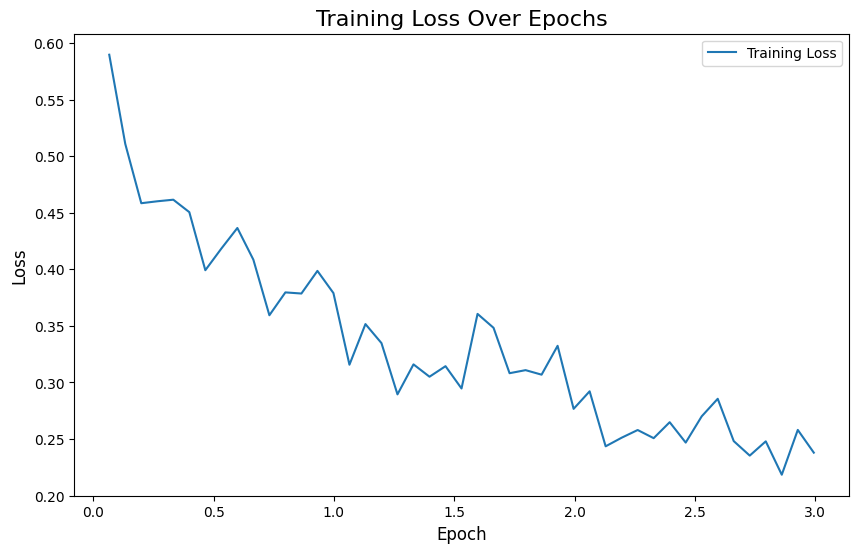

In [14]:
import matplotlib.pyplot as plt

train_loss = trainer.state.log_history
train_loss_epochs = [entry["epoch"] for entry in train_loss if "loss" in entry]
train_loss_values = [entry["loss"] for entry in train_loss if "loss" in entry]

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_epochs, train_loss_values, label="Training Loss")
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()


**Test the Model on New Data**

In [24]:
def predict_sentiment(text, model, tokenizer, max_len=256):
    # Tokenize input text
    encoding = tokenizer(
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    # Move tensors to GPU if available
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = logits.argmax(dim=1).item()

    return predicted_class  # Returns the predicted class (e.g., 0, 1, 2)

# Example test cases
print("Testing the model on example sentences...")
example_sentences = [
    "Tôi rất hài lòng với dịch vụ này!",  
    "vãi cứt.",               
    "đừng có nói chuyện mất dạy với tao",          
]

for sentence in example_sentences:
    prediction = predict_sentiment(sentence, model, tokenizer)
    print(f"Input: {sentence}")
    print(f"Predicted Sentiment: {prediction}")


Testing the model on example sentences...
Input: Tôi rất hài lòng với dịch vụ này!
Predicted Sentiment: 0
Input: vãi cứt.
Predicted Sentiment: 1
Input: đừng có nói chuyện mất dạy với tao
Predicted Sentiment: 0
